# Automatic translation of a R analysis to python

This notebook demonstrates automated translation on code produced during a live-coded data analysis in R.

The original analysis was done by David Robinson in this [youtube screencast](https://youtu.be/oYGi2wgSJaM), as part of [Tidy Tuesday](https://github.com/rfordatascience/tidytuesday). See the full code in [this notebook](https://github.com/dgrtwo/data-screencasts/blob/master/golden-age-tv.Rmd).

Currently, there are still some loose wires hanging out in this notebook!


In [1]:
import wrestlr
%load_ext wrestlr

In [2]:
from siuba import (
    _, group_by, mutate, summarize, filter, count,
    arrange, ungroup, top_n, inner_join
)
from plotnine import *

## Set up compatibility functions

Note that the code below is mostly...

* things that will be moved into the wrestlr
* small fixes that need to happen in siuba

In [3]:
import pandas as pd
from pandas import read_csv
from wrestlr.transformers import TransformExpr
from siuba.siu import create_sym_call, FuncArg, strip_symbolic, Symbolic, BinaryOp

# note: he uses dplyr::row_number, which in siuba lives in vector
# can create a namespace around dplyr funcs, but this works for now
from siuba.dply import vector

# Configure transformer class, to make functions like mean(x) -> x.mean() ----
t = TransformExpr(method_calls = {"mean": "mean", "sd": "std", "all": "all"})

# Configure custom R operations, like %in% ----
class user_op:
    @staticmethod
    def in_(x, y):
        """Corresponds to R's %in%"""
        if isinstance(x, Symbolic) or isinstance(y, Symbolic):
            return create_sym_call(FuncArg(user_op.in_), *map(strip_symbolic, [x,y]))
        
        # this is the worst, but 1 in some_series checks if 1 is in the index :/
        return x in y.array

# When dplyr is used like dplyr::row_number() ----
class dplyr:
    @staticmethod
    def row_number():
        return vector.row_number(_)

# Some misc dplyr / R functions I need to tweak in siuba ---
def n():
    return vector.n(_)

def desc(x):
    # TODO: need to update siuba's desc function w/ this
    return Symbolic(BinaryOp("__neg__", strip_symbolic(x)))


def factor(x):
    return pd.Categorical(x)



In [4]:
from wrestlr.magic import WrestlrMagic

WrestlrMagic.set_defaults(execute = True)

## Run translation

In [5]:
%%wrestlr -p -b -t t

tv_ratings <- read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-08/IMDb_Economist_tv_ratings.csv")

tv_ratings

tv_ratings = read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-08/IMDb_Economist_tv_ratings.csv"
)

tv_ratings



,titleId,seasonNumber,title,date,av_rating,share,genres
0,tt2879552,1,11.22.63,2016-03-10,8.4890,0.51,"Drama,Mystery,Sci-Fi"
1,tt3148266,1,12 Monkeys,2015-02-27,8.3407,0.46,"Adventure,Drama,Mystery"
2,tt3148266,2,12 Monkeys,2016-05-30,8.8196,0.25,"Adventure,Drama,Mystery"
3,tt3148266,3,12 Monkeys,2017-05-19,9.0369,0.19,"Adventure,Drama,Mystery"
4,tt3148266,4,12 Monkeys,2018-06-26,9.1363,0.38,"Adventure,Drama,Mystery"
...,...,...,...,...,...,...,...
2261,tt3250026,3,Zoo,2017-07-31,7.4132,0.09,"Drama,Mystery,Sci-Fi"
2262,tt3501584,1,iZombie,2015-04-28,8.4296,0.59,"Comedy,Crime,Drama"
2263,tt3501584,2,iZombie,2016-01-07,8.5641,0.43,"Comedy,Crime,Drama"
2264,tt3501584,3,iZombie,2017-05-16,8.4077,0.23,"Comedy,Crime,Drama"


tv_ratings >> count(_.seasonNumber) >> ggplot(aes("seasonNumber", "n")) + geom_line()



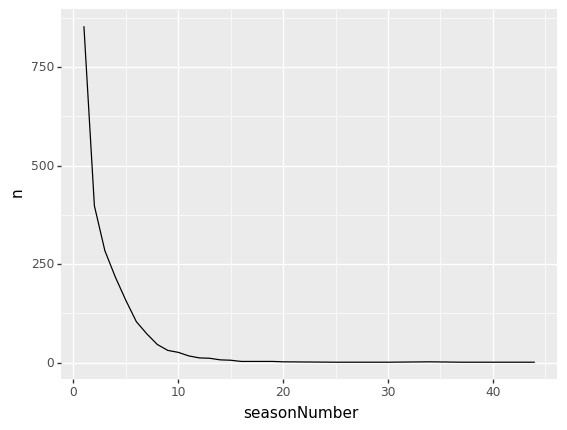

<ggplot: (301967813)>

In [6]:
%%wrestlr -p -b -x

tv_ratings %>%
  count(seasonNumber) %>%
  ggplot(aes(seasonNumber, n)) +
  geom_line()


You may be surprised it grouped the commands using `>>` in parentheses, with `+` on the outside. This is because in R, the `+` is actually the "top" node in the AST (it has a lower precedence).

tv_ratings >> filter(_.seasonNumber <= 7) >> group_by(_.seasonNumber) >> summarize(
    av_rating=_.av_rating.mean()
) >> ggplot(aes("seasonNumber", "av_rating")) + geom_line()



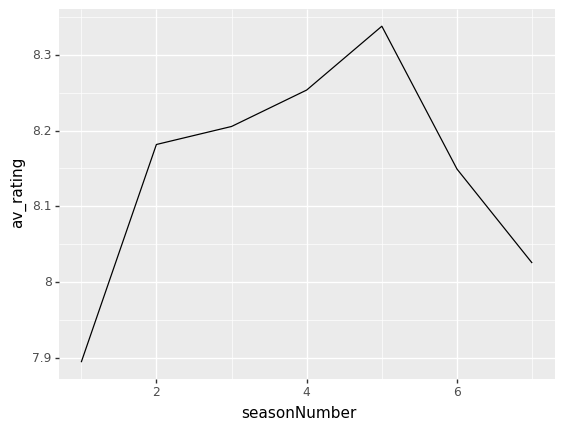

<ggplot: (-9223372036552781778)>

In [7]:
%%wrestlr -p -b -x -t t

tv_ratings %>%
  filter(seasonNumber <= 7) %>%
  group_by(seasonNumber) %>%
  summarize(av_rating = mean(av_rating)) %>%
  ggplot(aes(seasonNumber, av_rating)) +
  geom_line()



`dplyr::row_number()` seen as binary op being called

In [8]:
%%wrestlr -p -b -t t
tv_ratings_full_show <- tv_ratings %>%
  group_by(title) %>%
  filter(1 %in% seasonNumber,
         all(seasonNumber == dplyr::row_number()))


tv_ratings_full_show = (
    tv_ratings
    >> group_by(_.title)
    >> filter(
        user_op.in_(1, _.seasonNumber), (_.seasonNumber == dplyr.row_number()).all()
    )
)



tv_ratings_full_show >> filter(n() >= 5) >> filter(
    _.seasonNumber <= 5
) >> ungroup() >> ggplot(aes("factor(seasonNumber)", "av_rating")) + geom_boxplot()



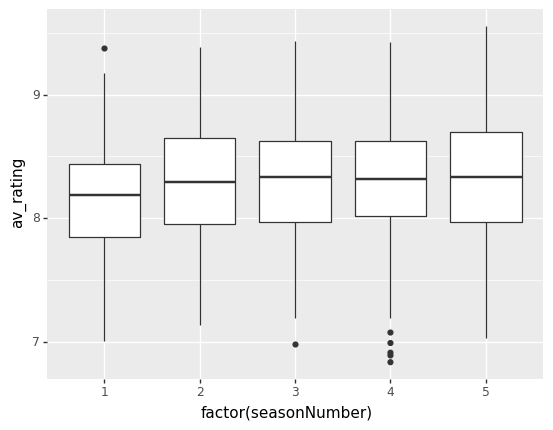

<ggplot: (301959432)>

In [9]:
%%wrestlr -p -b -x

tv_ratings_full_show %>%
  filter(n() >= 5) %>%
  filter(seasonNumber <= 5) %>%
  # TODO: MC note: ungrouped data, plotnine is not okay with grouped DFs
  #group_by(seasonNumber) %>%
  ungroup() %>%
  ggplot(aes(factor(seasonNumber), av_rating)) +
  geom_boxplot()

In [10]:
%%wrestlr -p -b -t t
by_show <- tv_ratings %>%
  group_by(title) %>%
  summarize(avg_rating = mean(av_rating),
            sd = sd(av_rating),
            seasons = n()) %>%
  arrange(desc(avg_rating))


by_show = (
    tv_ratings
    >> group_by(_.title)
    >> summarize(avg_rating=_.av_rating.mean(), sd=_.av_rating.std(), seasons=n())
    >> arrange(desc(_.avg_rating))
)



In [11]:
%%wrestlr -p -b -x
most_variable_shows <- by_show %>%
  filter(seasons >= 5) %>%
  top_n(6, sd)


most_variable_shows = by_show >> filter(_.seasons >= 5) >> top_n(6, _.sd)



visiting two table
most_variable_shows = by_show >> filter(_.seasons >= 5) >> top_n(6, _.sd)

tv_ratings >> inner_join(_, most_variable_shows, by="title") >> ggplot(
    aes("seasonNumber", "av_rating", "color=title")
) + geom_line() + geom_point() + facet_wrap("~title") + theme(legend_position="none")



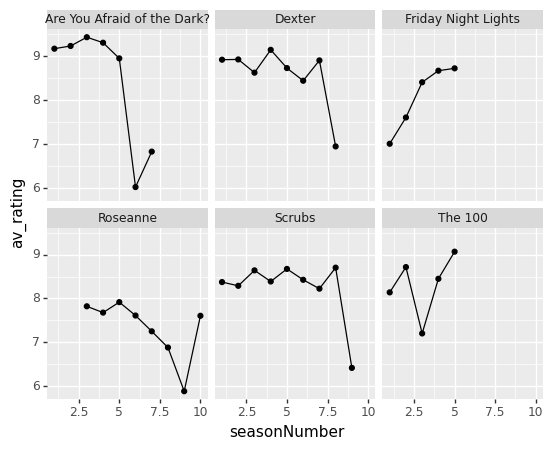

<ggplot: (-9223372036552739994)>

In [12]:
%%wrestlr -p -b -x
most_variable_shows <- by_show %>%
  filter(seasons >= 5) %>%
  top_n(6, sd)

tv_ratings %>%
  inner_join(most_variable_shows, by = "title") %>%
  ggplot(aes(seasonNumber, av_rating, color = title)) +
  geom_line() +
  geom_point() +
  # TODO: MC note: no handling of inline functions yet...
  #scale_x_continuous(breaks = function(lim) seq(floor(lim[1]), ceiling(lim[2]), 2)) +
  facet_wrap(~ title) +
  theme(legend.position = "none")